In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import h5py
import re
import matplotlib.lines as mlines

In [2]:
sns.set()

In [3]:
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
from keras.models import load_model
from scipy import stats

Using TensorFlow backend.


In [4]:
from Functions import position_gene, NFR_position, process
from MyModuleLibrary.mykeras.losses import correlate, mae_cor
from MyModuleLibrary.array_modifier import rolling_window

# Studying the mutazome

### Comparison with NFR position

The first study of the nucleazome is to represent it and the NFR position to see weither there is a match between high effect of mutations and being in NFR position.
Plotting the mean value of the nucleazome around NFR positions can help assessing this effect.

In [5]:
mutation_map = np.load('../Results_nucleosome/mutazome_CNN_nucleosome_in_vivo.npy')

In [6]:
mutation_map.shape

(948066, 4)

In [7]:
# Gene position in S.cerevisiae chromosome 16.
position = pd.read_csv('./Start_data/position_genes.txt')
position.head()

,chr,Start,Stop,Strand
0,XVI,280,6007,-
1,XVI,643,1125,+
2,XVI,1426,2001,+
3,XVI,7933,8427,-
4,XVI,9557,10870,-


In [8]:
# We import the experimental landscape of nucleosome on chromosome 16 of S.cerevisiae to find the NFR.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba = pd.read_csv('./Start_data/proba_in_vivo.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]

In [9]:
# Calculing the NFR position on chromosome 16 
nfr_position = NFR_position(y_true, HALF_WX, position)
nfr_start = nfr_position[nfr_position.strand == '+'].nfr_pos.values + HALF_WX
nfr_stop = nfr_position[nfr_position.strand == '-'].nfr_pos.values + HALF_WX
nfr_position = nfr_position.nfr_pos.values + HALF_WX # offset between mutazome and y_pred

In [10]:
z_score = np.sum(mutation_map[:605000], axis=1)
z_score = z_score - np.mean(z_score)
z_score /= np.std(z_score)

<IPython.core.display.Javascript object>


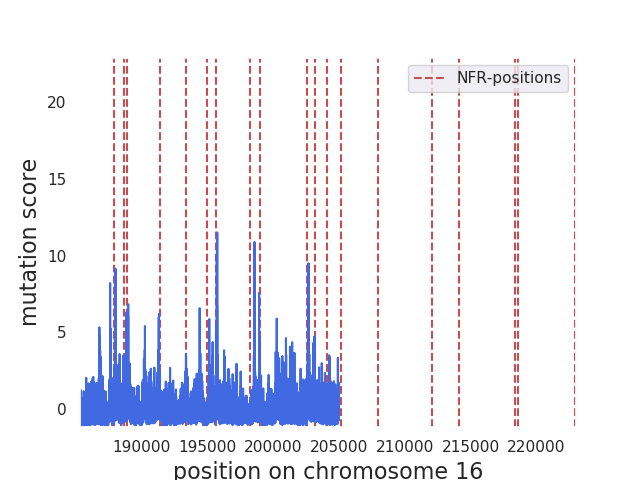

Text(0, 0.5, 'mutation score')

In [33]:
fig = plt.figure()

ax = plt.axes()
#plt.title('Muteazome on chr16 of S.cerevisiae')
for xc in nfr_position:
    plt.axvline(x=xc, color='r', linestyle='--')
#ax.plot(np.sum(mutation_map, axis=1), color='royalblue')
ax.plot(z_score, color='royalblue')
ax.set_facecolor('w')  
ax.legend(handles=[mlines.Line2D([], [], color='r', markersize=15, linestyle='--', label="NFR-positions")])
ax.set_xlabel('position on chromosome 16', fontsize=16)
ax.set_ylabel('mutation score', fontsize=16)

<IPython.core.display.Javascript object>


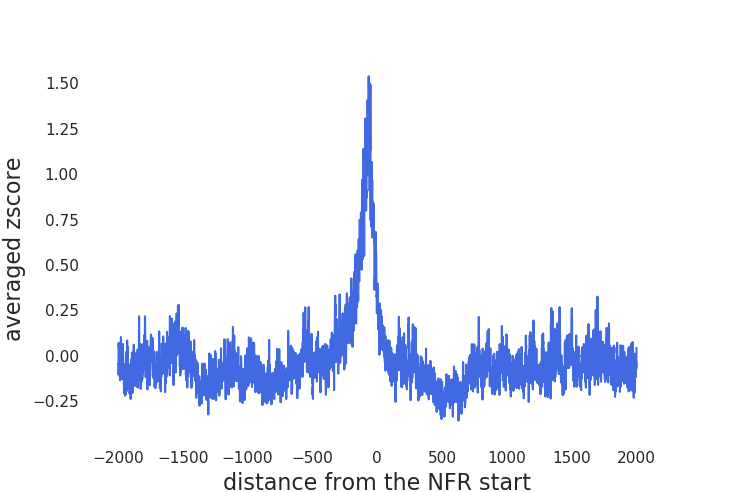

Text(0, 0.5, 'averaged zscore')

In [69]:
WX = 2000

nfr_start = nfr_start[1:]

z_score = np.sum(mutation_map[:205000], axis=1)
z_score = z_score - np.mean(z_score)
z_score /= np.std(z_score)

nfr_region_start = np.array([z_score[pos - WX : pos + WX] for pos in nfr_start[nfr_start < 200000]])
nfr_region_stop = np.array([z_score[pos - WX : pos + WX][::-1] for pos in nfr_stop[nfr_stop < 200000]])
nfr_region = np.append(nfr_region_start, nfr_region_stop, axis=0)

fig = plt.figure(figsize=(7, 4))
ax = plt.axes()
plt.plot(range(- WX, WX), np.mean(nfr_region, axis=0), color='royalblue')
ax.set_facecolor('w')  
#plt.title('Zscore moyen autour des NFR')
ax.set_xlabel('distance from the NFR start', fontsize=16)
ax.set_ylabel('averaged zscore', fontsize=16)

We study the coherence length in the mutazome

In [ ]:
nfr_distances = (nfr_position[1:] - nfr_position[:-1])
nfr_distances = nfr_distances[nfr_distances > 0]
nfr_distances = nfr_distances[nfr_distances < 4000]

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=100, num=1)
ax1.plot([pearsonr(z_score[i:], z_score[:-i])[0] for i in range(1, 4000)])
ax2.hist(nfr_distances, bins=20, density=False, histtype='step')
ax1.set(xlabel='Offset', ylabel='Autocorrelation of the mutazome')


### Important motives in nucleosome positioning

In [18]:
f = h5py.File('./seq_chr_sacCer3/sacCer3/chr16.hdf5',
              'r')
nucleotid = np.array(f['data'])
f.close()
nucleotid = nucleotid[:,0]

We look at the mean mutation score for every possible 5 bp motives.

In [11]:
def find_where(motif, end=605000):
    return np.where(np.sum((rolling_window(nucleotid[:end], window=5) == motif).astype(int), axis=1) == 5)[0] + 2

In [12]:
binding_sites = dict()
chars = True

with open('/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Start_data/PMW_binding_site.txt', 'r') as f:
    pattern = re.compile('>letter-probability matrix \w+: alength= \d+ w= \d+ nsites= \d+ E= \d+')
    
    while chars:
        chars = f.readline()
        
        if pattern.match(chars):
            name = re.findall("\w+:", chars)[0][:-1]
            size = int(re.findall("\d+", chars)[2])
        elif chars == '':
            print(chars)
        else:
            matrix = [[float(number) for number in re.findall("\d+\.\d+", chars)]]
            for i in range(size-1):
                line = f.readline()
                matrix.append([float(number) for number in re.findall("\d+\.\d+", line)])
            matrix = np.array(matrix)
            binding_sites[name] = matrix
                  

In [13]:
for name, array in binding_sites.items():
    for i in range(len(array)):
        array[i, :] /= np.sum(array[i, :])
    binding_sites[name] = array

In [14]:
num_letter = dict()

num_letter[1] = 'A'
num_letter[2] = 'T'
num_letter[3] = 'G'
num_letter[4] = 'C'

In [15]:
letter_num = dict()
for num, letter in num_letter.items():
    letter_num[letter] = num

In [16]:
mutation_peaks = np.where(z_score > 5)[0]
mutation_peaks.shape

(3444,)

In [ ]:
distance_to_nfr = list()

for peak in mutation_peaks:
    distance_to_nfr.append(np.min(np.abs(nfr_position - peak)))

In [ ]:
mutation_peaks = mutation_peaks[np.array(distance_to_nfr) < 200]
mutation_peaks.shape

In [ ]:
motives_ = np.array([nucleotid[peak - 2 : peak + 3] for peak in mutation_peaks])
motives, counts = np.unique(motives_, axis=0, return_counts=True)

sorter = np.argsort(counts)[::-1]
counts = counts[sorter]
motives = motives[sorter]

In [ ]:
from scipy.stats import binom_test

probabilities = dict()
p_value = dict()
list_of_counts = dict()

for motif, count in zip(motives, counts):
    str_motif = ''.join(num_letter[num] for num in motif)
    probabilities[str_motif] = len(find_where(motif)) / 605000.
    p_value[str_motif] = binom_test(x=count,
                                    n=len(mutation_peaks),
                                    p=probabilities[str_motif],
                                    alternative='greater')
    list_of_counts[str_motif] = count
    
    
p_value_array = np.array(list(p_value.values()))
list_of_motives = np.array(list(p_value.keys()))[np.where(p_value_array < 0.001)]
list_of_motives

In [ ]:
list_TTTTT = np.array(['TTTTT', 'TTTTC', 'ATTTT', 'CTTTT', 'TTTTA', 'GTTTT', 'TTGTC'])

list_AAAAA = np.array(['AAAAA', 'GAAAA', 'AAAAT', 'AAAAG','TAAAA',
                       'AAAAC', 'GACAA'])

list_GCGCG = np.array(['GCGCG','GCGAA','GCCGC', 'ACGCG', 'CCGCG', 'GCAGC', 'GCGCT',
                       'GCGCA', 'TCGCG', 'CCGCT', 'GCGGC','CCTCG', 'GCGCC','GCGGG',
                       'CCGCC', 'GCGGT','GCGGA', 'GCAGG', 'ACACG', 'GCTCG', 'GCGTG', 'GCGTC', 'GCGAG'])

list_CGCGC = np.array(['CGCGC', 'CGCGT','CCCGC', 'TTCGC','CTCGC', 'GCCGC','AGCGC', 'CGTGG', 'CGCGG', 'CGCGA',
                       'GGCGC', 'TGCGC', 'TCCGC','CGAGC', 'CCTGC','ACCGC', 'CACGC', 'CGAGA', 'ATCGC',
                       'AGCGG', 'GGCGG', 'GACGC','TGCGG', 'CCGGC', 'CACGG', 'CGAGG', 'CTCGG','ACACG', 'CGTGC',
                       'CCCGT','CCCGA', 'CGGGG'])

In [ ]:
total_count = np.sum(np.array(list(list_of_counts.values())))

for name, counts in list_of_counts.items():
    list_of_counts[name] /= total_count
list_of_counts

In [ ]:
def motif_to_one_hot(str_motif):
    motif = np.array([letter_num[letter] for letter in str_motif])
    one_hot_motif = np.zeros((5, 4))
    
    for i in range(5):
        one_hot_motif[i, motif[i] - 1] = 1
    return one_hot_motif

In [ ]:
list_of_motives_score = dict()

for str_motif in list_of_motives:
    motif = [letter_num[letter] for letter in str_motif]
    list_of_motives_score[str_motif] = np.mean(z_score[find_where(motif)])
list_of_motives_score   

In [ ]:
for motif in list_of_motives:
    plot_logo(motif_to_one_hot(motif))

In [ ]:
def non_linearity(num):
    return num**2

In [ ]:
binding_score = dict()

for name, binding_site in binding_sites.items():
    bind_score = 0
    
    if name != 'ZMS1':
        decomposition = rolling_window(binding_site, window=(5,4)).reshape((-1, 5, 4))
    
        for motif in list_of_motives:
            one_hot_motif = motif_to_one_hot(motif)
            weight = list_of_counts[motif]
            bind_score += weight * np.mean([non_linearity(np.sum(np.multiply(decomposition[i], one_hot_motif))) for i in range(len(decomposition))])

    binding_score[name] = bind_score

In [ ]:
mean_score = 0
decomposition = np.ones((1, 5, 4)) * 0.25

for motif in list_of_motives:
    one_hot_motif = motif_to_one_hot(motif)
    weight = list_of_counts[motif]
    mean_score += weight * np.mean([non_linearity(np.sum(np.multiply(decomposition[i], one_hot_motif))) for i in range(len(decomposition))])

mean_score    

In [ ]:
scores = np.array(list(binding_score.values()))
scores = (scores - mean_score) / np.std(scores)

In [ ]:
for i in range(len(scores)):
    binding_score[list(binding_score.keys())[i]] = scores[i]

In [ ]:
fig, ax = plt.subplots()

ax.hist(list(binding_score.values()), bins=100)

In [ ]:
np.array(list(binding_score.keys()))[np.argsort(np.array(list(binding_score.values())))[::-1]][:10]

In [ ]:
binding_score['RAP1']

In [ ]:
for motif in np.array(list(binding_score.keys()))[np.argsort(np.array(list(binding_score.values())))[::-1]][:10]:
    plot_logo(binding_sites[motif])

In [ ]:
for name, score  in binding_score.items():
    print(name, score)
    plot_logo(binding_sites[name])

In [ ]:
fp = FontProperties(family="Arial", weight="bold") 
globscale = 1.35
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}

def _letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_logo(motif, index=None):
    """
        Plot a logo associated to a motif, the motif must be a numpy array with 1 standing for A, 2 for T, 3 for G
        and 4 for C.
    """
    #motif = (np.arange(4) == motif[...,None]-1).astype(int)
    #motif = motif.reshape((motif.shape[0], 4))

    fig, ax = plt.subplots(figsize=(5,3))
    all_scores = [[('A', motif[i, 0]),
                   ('T', motif[i, 1]),
                   ('G', motif[i, 2]),
                   ('C', motif[i, 3])] for i in range(motif.shape[0])]
    ax.set_facecolor('w')   
    ax.set_axis_off()
    
    if index is not None:
        ax.text(0, 1.1, 'Distance to NFR: {}'.format(mode_distances_to_nfr[index]))
        ax.text(0, 1.25, 'Mean peaks height: {}'.format(mean_motives_score[index]))

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            _letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.tight_layout()  
    plt.show()

## Positioning or anti-positioning motifs

We try to predict the effect of the motifs found to be important in the process of nucleosome positioning.
To do so we predict the wilde type occupancy near the motif and compare it with the mutated type coverage.

In [19]:
mutation_peaks
motives_ = np.array([nucleotid[peak - 2 : peak + 3] for peak in mutation_peaks])
motives, counts = np.unique(motives_, axis=0, return_counts=True)

In [20]:
def position_motif(motif):
    pos_in_motives_ = np.where(np.sum((motives_ == motif).astype(int), axis=1) == 5)[0]
    return mutation_peaks[pos_in_motives_]

In [21]:
def predict_around(positions, width):
    """
    Function aimed at predicting the wild type and the 3 mutated type coverage around position in positions.
    The coverage is predicted with a range width around the center position.
    
    Args:
        positions: positions around which to predict the coverage (positions of mutation also)
        width: the coverage will be predicted within a width range around positions
    """
    model = load_model('../Results_nucleosome/weights_CNN_nucleosome_in_vivo.hdf5',
                       custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})
    f = h5py.File('./seq_chr_sacCer3/sacCer3/chr16.hdf5',
              'r')
    nucleotid = np.array(f['data'])
    f.close()
    nucleotid = nucleotid[:,0]
    window = 2001
    half_wx = window // 2
    pred_around = np.zeros((len(positions), 2 * width, 4))
    
    for i in range(4):    
        nucleotid_around = np.array([nucleotid[pos - width - half_wx : pos + width + half_wx] for pos in positions])
        nucleotid_around[:, half_wx + width] = ((nucleotid_around[:, half_wx + width] + i) % 4) + 1
        
        nucleotid_around = rolling_window(nucleotid_around, window=(len(nucleotid_around), window))
        nucleotid_around = np.swapaxes(nucleotid_around, 1, 2)
        nucleotid_around = nucleotid_around.reshape(nucleotid_around.shape[1] * 2 * width, window)
        
        x_one_hot = (np.arange(nucleotid_around.max()) == nucleotid_around[...,None]-1).astype(int)
        x = x_one_hot.reshape((-1, window, 4, 1))
        
        pred_around_ = model.predict(x)
        pred_around_ = pred_around_.reshape((len(positions), 2 * width))
        pred_around[:, :, i] = pred_around_
    return pred_around

In [22]:
def plot_effect_mutation(list_of_motifs, width):
    for motif in list_of_motifs:
        pred = predict_around(position_motif([letter_num[i] for i in motif]), width)
        fig = plt.figure(figsize=(10,3))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(range(-width, width), np.mean(pred, axis=0)[:, 3],
                 'royalblue',
                 label='WT')
        ax1.plot(range(-width, width), np.mean(np.mean(pred, axis=0)[:, :3], axis=1),
                 'r',
                 label='Mutated')
        ax1.legend()
        ax1.set_facecolor('w')  
        ax1.set_xlabel('distance to the motif center', fontsize=16)
        ax1.set_ylabel('mean coverage', fontsize=16)
        
        #ax2 = fig.add_subplot(1, 2, 2)
        #ax2.set_facecolor('w')  
        #ax2.bar(range(5),
        #        np.mean(np.array([z_score[pos - 2 : pos + 3]\
        #                          for pos in position_motif([letter_num[i] for i in motif])]), axis=0),
        #        color='royalblue',
        #        width=0.5)
        #ax2.set_ylabel('mean mutation score', fontsize=16)
        #ax2.set_xticks(range(5))
        #ax2.set_xticklabels(motif, fontsize=30)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


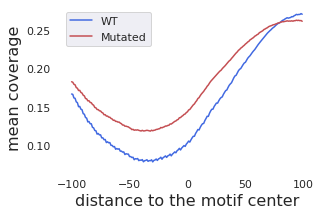

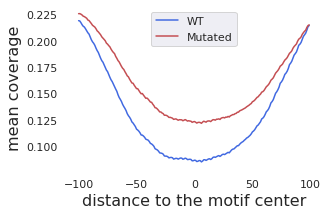

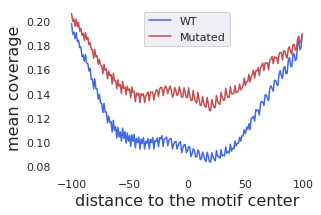

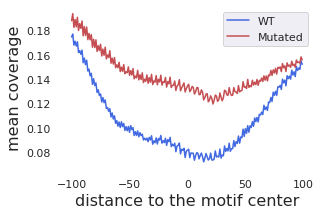

In [23]:
plot_effect_mutation(['AAAAA', 'TTTTT', 'CGCGC', 'GCGCG'], width=100) 

We try to see weither the poly dT-dA are mostly set in the NFR while the CGCGC motifs are in the TSS region.

In [ ]:
position_tss = np.append(position[position.Strand == '+'].Start.values,
                         position[position.Strand == '-'].Stop.values)

In [ ]:
def distance_to_tss(motif):
    """ Return the list of distance between all instance of the motifs and the closest TSS."""
    motif = [letter_num[letter] for letter in motif]
    return [np.min(np.abs(position_tss - motif_pos)) for motif_pos in position_motif(motif)]

In [ ]:
for motif in list_GCGCG:
    print('motif : {}, distance to tss : {}'.format(motif, np.mean(distance_to_tss(motif))))

## Visualizing the ConvNet activation

In [ ]:
from keras.models import load_model
from keras import models

In [ ]:
f = h5py.File('./seq_chr_sacCer3/sacCer3/chr16.hdf5',
              'r')
nucleotid = np.array(f['data'])
f.close()
nucleotid = nucleotid[:,0]

X =  (np.arange(4) == nucleotid[...,None]-1).astype(int)
X = X.reshape((X.shape[0], 4))

In [ ]:
X.shape

In [ ]:
model = load_model('../Results_nucleosome/weights_CNN_nucleosome_in_vivo.hdf5',
                   custom_objects={'correlate': correlate,
                                   'mae_cor': mae_cor})

In [ ]:
def plot_activations(nfr_num, nfr_offset):
    xc = 250 - nfr_offset // 4

    start = nfr_position[nfr_num] - 1000 + nfr_offset
    img_tensor = X[start : start + 2001].reshape(1, 2001, 4, 1)
    img_tensor.shape

    activations = activation_model.predict(img_tensor)

    fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)

    axes[0, 0].plot(activations[8][0, :, 0, 0])
    axes[0, 0].axvline(x=xc, color='r', linestyle='--')

    axes[0, 1].plot(activations[8][0, :, 0, 1])
    axes[0, 1].axvline(x=xc, color='r', linestyle='--')

    axes[1, 0].plot(activations[8][0, :, 0, 2])
    axes[1, 0].axvline(x=xc, color='r', linestyle='--')

    axes[1, 1].plot(activations[8][0, :, 0, 3])
    axes[1, 1].axvline(x=xc, color='r', linestyle='--')

    axes[2, 0].plot(activations[8][0, :, 0, 4])
    axes[2, 0].axvline(x=xc, color='r', linestyle='--')

    axes[2, 1].plot(activations[8][0, :, 0, 5])
    axes[2, 1].axvline(x=xc, color='r', linestyle='--')

    axes[3, 0].plot(activations[8][0, :, 0, 6])
    axes[3, 0].axvline(x=xc, color='r', linestyle='--')

    axes[3, 1].plot(activations[8][0, :, 0, 7])
    axes[3, 1].axvline(x=xc, color='r', linestyle='--')

    print(activations[13][0, 0])

In [ ]:
for nfr_offset in np.arange(-1000, 1000, 100):
    plot_activations(10, nfr_offset)

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(start + 1, start + 2000),
        activations[0][0, :, 0, 62])
ax.set_xticks(np.arange(start + 1, start + 2000))
ax.set_xticklabels(nucleotid[start  + 1: start + 2000].astype(int))

In [ ]:
images = np.zeros(64, 3, 1, 4)
kernel_images = np.zeros(64, 3, 4)
a = 0

while a < 64:
    for i in range(4):
        for j in range(4):
            for k in range(4):
                images[a, i, j, k] = 1
    a += 1

kernel_images_weights = np.zeros(64)
    
for i in range(64):
    kernel_weights = model.layers[0].get_weights()[0][:, :, :, i]
    kernel_images_weights[i] = np.
    


#### Experimental p-value

In [ ]:
p_value = np.zeros(counts.shape)
TRIES = 100
N = mutation_peaks.shape[0]
k = -1

for motif, count in zip(motives, counts):
    k += 1
    
    rand_motives = np.array([nucleotid[i - 2 : i + 3] for i in np.random.randint(3, nucleotid.shape[0] - 3, N * TRIES)])
    
    indicators = np.sum(np.abs(rand_motives - motif), axis=1)
    indicators *= -1
    indicators[indicators == 0] = 1
    indicators[indicators < 0] = 0
    
    cumsum = np.cumsum(indicators)
    cumsum = cumsum[N:] - cumsum[: -N]
    
    indexes = [N*i for i in range(TRIES - 1)]
    cumsum = cumsum[indexes]    
    
    p_value[k] = len(np.where(cumsum >= count)[0])

print(p_value)

# Designing a sequence

We design a sequence of 167 bp to use as a nucleosome setter. We select the mutation that help positioning the nucleosome as we want by a Metropolis algorithm.

In [ ]:
seq = np.load('../Results_nucleosome/designed_sequence.npy')
x_seq = process(seq)

model = load_model('../Results_nucleosome/weights_collaborator_WT_167_rep1.hdf5',
                  custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})

In [ ]:
y_syn = model.predict(x_seq)
plt.plot(y_syn)